<a href="https://colab.research.google.com/github/LoukiaPavlana/Advanced-Databases/blob/main/LSTM_Model_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM
* LSTMs are a type of recurrent neural network (RNN) designed to handle sequential data.

* They use internal memory cells to retain information from previous time steps.

* LSTMs are especially useful for time series because they can model temporal dependencies, capturing relationships between past values and future predictions.

* Unlike regression models  LSTM models require a 3D array as input, with dimensions (samples, timesteps, features).

* This structure is necessary to feed sequential data into the model.

* Here, timesteps refers to the number of previous time steps the model will look back to make a prediction.

* LSTMs inherently account for temporal dependencies, meaning we do not need to engineer lagged features manually.
The model can be trained to "remember" past sequences and use them to predict future values.


**Data Preparation:** We need to reshape the data into sequences suitable for LSTM.


**Units:**

Units refers to the number of neurons (also called "units") in the LSTM layer.

* *Function:* Each neuron in the LSTM layer learns patterns in the input data sequence. Increasing units makes the model more expressive, allowing it to capture more complex patterns. However, more units also increase model complexity, which can lead to longer training times and potentially overfitting if there isn’t enough data.

* *Effect on Results:* A higher number of units may improve accuracy if the model previously lacked capacity, but it also increases computational cost and might lead to overfitting.

**Dropout:**
dropout is a regularization technique that randomly drops out a proportion (in this case, 20%) of the neurons in the layer during training.

* *Function:* By temporarily deactivating some neurons at each training step, dropout prevents neurons from co-adapting too strongly to specific features. This helps the model generalize better and reduces overfitting.
* *Effect on Results:* Dropout often improves the model’s performance on test data by making it less prone to overfitting. However, too much dropout can result in underfitting, where the model struggles to capture patterns in the data.

**Timesteps:**
Timesteps defines the number of previous time steps in the sequence that the model will consider when making a prediction.
* *Function:* In this case, the model looks back over the last 7 time steps (e.g., the last 7 hours or days, depending on your data’s granularity) to make a prediction.
* *Effect on Results:* A higher number of timesteps gives the model more historical data to consider, potentially improving accuracy if past data is highly informative. However, longer sequences also increase computational complexity and might include unnecessary information, leading to worse performance.

**learning_rate:**
Learning_rate is a parameter that controls the step size during optimization. A learning rate of 0.001 means the model’s weights are updated by a factor of 0.001 of the calculated gradient during each optimization step.
* *Function:* The learning rate determines how quickly or slowly a model learns. A lower learning rate makes learning slower but can lead to a more stable convergence to the minimum loss. A higher learning rate speeds up learning but may cause the model to miss the optimal point or oscillate around it.
* *Effect on Results:* If the learning rate is too high, the model may not converge well, resulting in high loss values. If it’s too low, training will be slower and may lead to underfitting, where the model doesn't learn effectively within the given number of epochs.

**Layers:**
Layers specifies the number of LSTM layers in the model architecture. Here, the model contains just one LSTM layer, followed by a Dense layer for the output.

* *Function:* Adding more LSTM layers can increase the model’s capacity to learn complex temporal relationships in data, as each LSTM layer can learn a representation that is passed to the next layer for further refinement.

* *Effect on Results:* Adding more layers generally improves model performance, especially with complex time series data, but it also increases the risk of overfitting and requires more computation. A single-layer LSTM is simpler and faster, but it might not capture deeper dependencies in the data.


In summary:
**Lower timesteps** may make the model focus on **shorter-term patterns**, whereas **higher timesteps** help it recognize **longer-term trends** but can **increase** the model **complexity**.

**Higher units** provide the model with **greater capacity** but can **lead** to **overfitting** if too many neurons are used.
**Higher dropout** **prevents overfitting** but can **hinder** the model’s **ability** to **capture patterns** if set too high.

**Higher learning rates** speed up training but might **miss the optimal solution**, while **lower learning rates** can help reach a **more stable** and **precise minimum**.

In [ ]:
import os
import holidays  # Import the holidays library to find Greek Holidays
import pandas as pd
from IPython.display import display
import warnings
import matplotlib.pyplot as plt
import glob
import openpyxl
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install holidays
!pip install catboost
!pip install pmdarima
!pip install xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.4 MB/s eta 0:00:00


From the previous notebook we have concluded that timesteps: 168 is the best thus far


In [ ]:
combined_df = pd.read_csv('/content/drive/MyDrive/Day-Ahead-Market-Data/Combined_PreMarketSummary_Added_Features_df_2023_2024.csv')
# Create the features
df = combined_df.copy()
display(df)
def parse_date(date_str):
    """
    Function to parse individual date strings based on their format.
    """
    try:
        # Try parsing with full datetime format
        return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')
    except ValueError:
        try:
            # Try parsing with date-only format
            return pd.to_datetime(date_str, format='%Y-%m-%d')
        except ValueError:
            # If parsing fails, return NaT (you can choose to handle differently here)
            print(f"Unrecognized format: {date_str}")
            return pd.NaT

# Apply the custom parsing function to each row in the Date column
df['Date'] = df['Date'].apply(parse_date)

# Create a Greece holiday calendar for the relevant years
gr_holidays = holidays.Greece(years=[2023,2024])

# Add the is_holiday column: 1 if holiday, 0 otherwise
df['is_holiday'] = df['Date'].apply(lambda x: 1 if x in gr_holidays else 0)


df['Month'] = df['Date'].dt.month
df['Hour'] = df['Hour'].apply(lambda x: 0 if x == 24 else x)
df['Day of Month']=df['Date'].dt.day
df['Day of Year']=df['Date'].dt.dayofyear
df['Week of Year']=df['Date'].dt.isocalendar().week # ISO calendar year starts with the week that includes the first Thursday of the year -> 1/1/2023 -> week 52
df['Is Weekend'] = df['Day of the Week'].isin([7, 1]).astype(int)
df = df.drop(df.columns[:1], axis=1)
df = df[['Date','Hour','Month', 'Day of Month', 'Day of the Week', 'Day of Year', 'Week of Year', 'Is Weekend','is_holiday','Is Holiday','Market Clearing Price', 'Total BUY Nominations:Greece Mainland', 'Total SELL Nominations:Greece Mainland', 'PRODUCTION LIGNITE', 'PRODUCTION GAS', 'PRODUCTION HYDRO', 'PRODUCTION RENEWABLES', 'TOTAL PRODUCTION', 'DEMAND HV LOAD', 'DEMAND LV LOAD', 'DEMAND MV LOAD', 'DEMAND PUMP', 'DEMAND SYSTEM LOSSES', 'TOTAL DEMAND', 'IMPORTS AL-GR', 'IMPORTS MK-GR', 'IMPORTS BG-GR', 'IMPORTS TR-GR', 'IMPORTS IT-GR', 'TOTAL IMPORTS', 'EXPORTS GR-AL', 'EXPORTS GR-MK', 'EXPORTS GR-BG', 'EXPORTS GR-TR', 'EXPORTS GR-IT', 'TOTAL EXPORTS']]
# Rolling window statistics
df['rolling_mean_24'] = df['Market Clearing Price'].rolling(window=24).mean()  # 24-hour rolling mean
df['rolling_std_24'] = df['Market Clearing Price'].rolling(window=24).std()    # 24-hour rolling std
df['rolling_min_24'] = df['Market Clearing Price'].rolling(window=24).min()    # 24-hour rolling min
df['rolling_max_24'] = df['Market Clearing Price'].rolling(window=24).max()    # 24-hour rolling max
# Rolling statistics
df['rolling_mean_6'] = df['Market Clearing Price'].rolling(window=6).mean()
df['rolling_std_6'] = df['Market Clearing Price'].rolling(window=6).std()
df['rolling_min_6'] = df['Market Clearing Price'].rolling(window=6).min()
df['rolling_max_6'] = df['Market Clearing Price'].rolling(window=6).max()

df['rolling_mean_7d'] = df['Market Clearing Price'].rolling(window=7).mean()
df['rolling_std_7d'] = df['Market Clearing Price'].rolling(window=7).std()
df['rolling_min_7d'] = df['Market Clearing Price'].rolling(window=7).min()
df['rolling_max_7d'] = df['Market Clearing Price'].rolling(window=7).max()

display(df)
# Create lagged features
df['lag_1_hour'] = df['Market Clearing Price'].shift(1)  # 1-hour lag
df['lag_24_hour'] = df['Market Clearing Price'].shift(24)  # 24-hour lag
df['lag_6_hour'] = df['Market Clearing Price'].shift(6)   # Lag of 6 hours
df['lag_48_hour'] = df['Market Clearing Price'].shift(48) # Lag of 48 hours

spike_threshold = df['Market Clearing Price'].mean() + 2 * df['Market Clearing Price'].std()
df['is_spike'] = (df['Market Clearing Price'] > spike_threshold).astype(int)

# Lagged rolling mean
df['lagged_rolling_mean_6'] = df['Market Clearing Price'].shift(6).rolling(window=6).mean()
df['lagged_rolling_mean_24'] = df['Market Clearing Price'].shift(24).rolling(window=6).mean()
df['lagged_rolling_std_6'] = df['Market Clearing Price'].shift(6).rolling(window=6).std()

df['BUY-SELL NOM']=df['Total BUY Nominations:Greece Mainland']-df['Total SELL Nominations:Greece Mainland']
df['PROD-DMND']=df['TOTAL PRODUCTION']-df['TOTAL DEMAND']

#Percentage change compared to previous hours
df['pct_change_1h'] = df['Market Clearing Price'].pct_change(1)
df['pct_change_6h'] = df['Market Clearing Price'].pct_change(6)
df['pct_change_24h'] = df['Market Clearing Price'].pct_change(24)
#Difference between consecutive time steps
df['price_gradient_1h'] = df['Market Clearing Price'] - df['Market Clearing Price'].shift(1)

# Rolling and lagged for
df['rolling_mean_demand_24'] = df['TOTAL DEMAND'].rolling(window=24).mean()
df['rolling_std_demand_24'] = df['TOTAL DEMAND'].rolling(window=24).std()
df['rolling_mean_production_24'] = df['TOTAL PRODUCTION'].rolling(window=24).mean()
df['lag_demand_1h'] = df['TOTAL DEMAND'].shift(1)
df['lag_production_1h'] = df['TOTAL PRODUCTION'].shift(1)

#Production-Demand Ratio
df['prod_demand_ratio'] = df['TOTAL PRODUCTION'] / (df['TOTAL DEMAND'] + 1e-6)

#Imports-Exports Ratio
df['imports_exports_ratio'] = df['TOTAL IMPORTS'] / (df['TOTAL EXPORTS'] + 1e-6)

#Renewables-Production Ratio
df['renewables_prod_ratio'] = df['PRODUCTION RENEWABLES'] / (df['TOTAL PRODUCTION'] + 1e-6)

#Market Imbalance
df['market_imbalance'] = df['BUY-SELL NOM'] + df['PROD-DMND']

#Surplus/Deficit Indicator
df['surplus_deficit'] = (df['market_imbalance'] > 0).astype(int)


# Rolling mean and standard deviation over 24 and 168 steps
df['rolling_mean_24h'] = df['Market Clearing Price'].rolling(window=24).mean()
df['rolling_std_24h'] = df['Market Clearing Price'].rolling(window=24).std()

df['rolling_mean_7d'] = df['Market Clearing Price'].rolling(window=24 * 7).mean()
df['rolling_std_7d'] = df['Market Clearing Price'].rolling(window=24 * 7).std()


# Exponential moving standard deviation with a smoothing factor
df['ema_std_24h'] = df['Market Clearing Price'].ewm(span=24).std()

# Lagged standard deviation (e.g., standard deviation of the last 24 hours)
df['lagged_std_24h'] = df['Market Clearing Price'].shift(24).rolling(window=24).std()

# Standard deviation of Market Clearing Price by Hour of the Day
hourly_std = df.groupby('Hour')['Market Clearing Price'].std()
df['hourly_std'] = df['Hour'].map(hourly_std)

# Standard deviation of Market Clearing Price by Day of the Week
dow_std = df.groupby('Day of the Week')['Market Clearing Price'].std()
df['dow_std'] = df['Day of the Week'].map(dow_std)

# Standard deviation of Market Clearing Price by Month of the Year
monthly_std = df.groupby('Month')['Market Clearing Price'].std()
df['monthly_std'] = df['Month'].map(monthly_std)

#Standard Deviation of Differences (Rate of Change)
# Compute the difference between consecutive values
df['diff'] = df['Market Clearing Price'].diff()

# Calculate the rolling standard deviation of the differences
df['rolling_std_diff'] = df['diff'].rolling(window=24).std()

#Max Values: Include rolling maximum and minimum prices over key windows
df['rolling_max_24h'] = df['Market Clearing Price'].rolling(window=24).max()
df['rolling_min_24h'] = df['Market Clearing Price'].rolling(window=24).min()

# Cyclical features for "Hour"
df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

#Peak-to-Peak Range: Difference between rolling max and min
df['rolling_range_24h'] = df['rolling_max_24h'] - df['rolling_min_24h']


#Coefficient of Variation: Combine standard deviation with the mean
df['cv_24h'] = df['rolling_std_24h'] / df['rolling_mean_24h']

#Z-Score of Price: Highlight deviations from the mean
df['price_z_score'] = (df['Market Clearing Price'] - df['rolling_mean_24h']) / df['rolling_std_24h']

# Create lagged features
df['Price_1_hour_ago'] = df['Market Clearing Price'].shift(1)
df['Price_2_hour_ago'] = df['Market Clearing Price'].shift(2)
df['Price_24_hours_ago'] = df['Market Clearing Price'].shift(24)
df['Price_168_hours_ago'] = df['Market Clearing Price'].shift(168)  # Lag of one week (7 days * 24 hours)
df['Price_1_month_ago'] = df['Market Clearing Price'].shift(24 * 30)  # Approximate lag of one month

# Create lagged features
df['Price_1_hour_ago'] = df['Market Clearing Price'].shift(1)
df['Price_2_hours_ago'] = df['Market Clearing Price'].shift(2)
df['Price_6_hours_ago'] = df['Market Clearing Price'].shift(6)
df['Price_24_hours_ago'] = df['Market Clearing Price'].shift(24)
df['Price_168_hours_ago'] = df['Market Clearing Price'].shift(168)  # Lag of one week (7 days * 24 hours)
df['Price_1_day_ago'] = df['Market Clearing Price'].shift(24*7)
df['Price_1_month_ago'] = df['Market Clearing Price'].shift(24 * 30)  # Approximate lag of one month

# Calculate hourly peak volatility (standard deviation of Market Clearing Price for each hour)
hourly_peak_volatility = df.groupby('Hour')['Market Clearing Price'].std()

# Map the calculated peak volatility back to the dataframe
df['hourly_peak_volatility'] = df['Hour'].map(hourly_peak_volatility)

# Replace inf and -inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values
df['pct_change_1h'].fillna(df['pct_change_1h'].mean(), inplace=True)
df['pct_change_24h'].fillna(df['pct_change_24h'].mean(), inplace=True)
df['pct_change_6h'].fillna(df['pct_change_6h'].mean(), inplace=True)

# Check again
print("After handling, remaining infinity values:")
print(df.isin([np.inf, -np.inf]).sum())

print("\nRemaining NaN values:")
print(df.isna().sum())

combined_df=df.copy()


#GridSearch


In [ ]:
!pip install scikeras

In [ ]:
!pip install --upgrade scikeras


In [ ]:
!pip install --upgrade scikeras scikit-learn

##M6


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Grid Search Results:


,model,feature_set,date_range,batch_size,dropout_rate,epochs,learning_rate,units,MAE,MSE,R2
0,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,25,0.0010,64,0.028019,0.002543,0.354449
1,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,25,0.0010,128,0.026308,0.002172,0.374774
2,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,25,0.0005,64,0.030964,0.002817,0.295334
3,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,25,0.0005,128,0.027777,0.002292,0.385859
4,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,50,0.0010,64,0.026296,0.002661,0.360474
5,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,50,0.0010,128,0.028778,0.002835,0.258803
6,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,50,0.0005,64,0.026317,0.002317,0.380029
7,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,50,0.0005,128,0.026839,0.002409,0.361025
8,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.3,25,0.0010,64,0.029117,0.002757,0.321646
9,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.3,25,0.0010,128,0.026560,0.002270,0.403821


Feature Set: LSTM_M6
Best Parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 25, 'learning_rate': 0.001, 'units': 128}
Best CV Score (MSE): -0.0021722286862010756
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Feature set: ['Market Clearing Price', 'Hour']


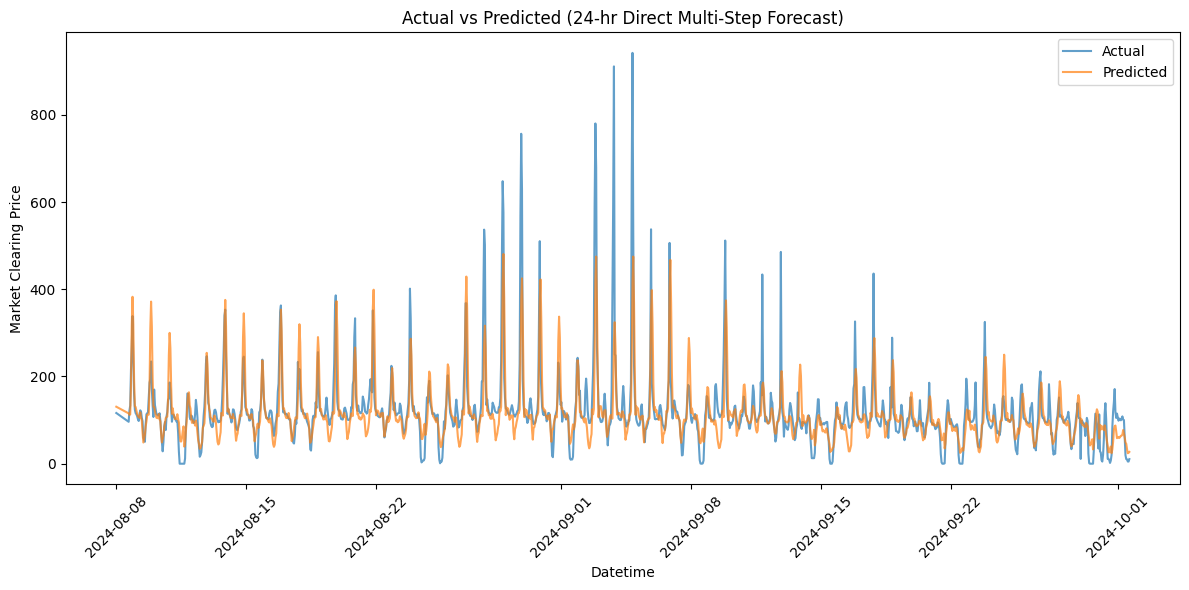

Overall Multi-Step Forecast Results:


,model,feature_set,date_range,mae,mse,r2,best_params
0,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,33.127609,3472.206787,0.54109,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch..."


                                               params  mean_test_MSE  \
0   {'batch_size': 32, 'dropout_rate': 0.2, 'epoch...      -0.002543   
1   {'batch_size': 32, 'dropout_rate': 0.2, 'epoch...      -0.002172   
2   {'batch_size': 32, 'dropout_rate': 0.2, 'epoch...      -0.002817   
3   {'batch_size': 32, 'dropout_rate': 0.2, 'epoch...      -0.002292   
4   {'batch_size': 32, 'dropout_rate': 0.2, 'epoch...      -0.002661   
5   {'batch_size': 32, 'dropout_rate': 0.2, 'epoch...      -0.002835   
6   {'batch_size': 32, 'dropout_rate': 0.2, 'epoch...      -0.002317   
7   {'batch_size': 32, 'dropout_rate': 0.2, 'epoch...      -0.002409   
8   {'batch_size': 32, 'dropout_rate': 0.3, 'epoch...      -0.002757   
9   {'batch_size': 32, 'dropout_rate': 0.3, 'epoch...      -0.002270   
10  {'batch_size': 32, 'dropout_rate': 0.3, 'epoch...      -0.002462   
11  {'batch_size': 32, 'dropout_rate': 0.3, 'epoch...      -0.002510   
12  {'batch_size': 32, 'dropout_rate': 0.3, 'epoch...      -0.00

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# -------------------------------
# Custom Keras Regressor Wrapper
# -------------------------------
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, units=128, dropout_rate=0.2, learning_rate=0.001, batch_size=32, epochs=25, num_features=None):
        self.units = units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.num_features = num_features
        self.model = None

    def create_model(self):
        model = Sequential()
        model.add(LSTM(self.units, input_shape=(config['timesteps'], self.num_features), return_sequences=True))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(self.units // 2, return_sequences=False))
        model.add(Dense(self.units, activation='relu'))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(self.units // 2, activation='relu'))
        model.add(Dense(config['output_steps']))
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def fit(self, X, y):
        self.model = self.create_model()
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X)

# -------------------------------
# Configuration
# -------------------------------
feature_sets = [
    {'name': 'LSTM_M6', 'features': ['Market Clearing Price', 'Hour']},
]

date_ranges = [
    ("2024-01-01", "2024-10-01")
]

config = {
    'name': 'Direct Multi-Step LSTM (24-hour forecast)',
    'timesteps': 168,   # input window size
    'output_steps': 24, # forecast horizon (24 hours)
    'learning_rate': 0.001,
    'clipvalue': 1.0
}

# -------------------------------
# Helper Functions
# -------------------------------
def scale_features_with_one_hot(df, feature_set):
    scalers = {}
    scaled_df = df.copy()

    # One-hot encoding for 'Day of the Week' and 'Hour'
    if 'Day of the Week' in feature_set:
        one_hot = pd.get_dummies(df['Day of the Week'], prefix='DOW')
        scaled_df = pd.concat([scaled_df, one_hot], axis=1)
        feature_set = [col for col in feature_set if col != 'Day of the Week'] + list(one_hot.columns)

    if 'Hour' in feature_set:
        one_hot = pd.get_dummies(df['Hour'], prefix='Hour')
        scaled_df = pd.concat([scaled_df, one_hot], axis=1)
        feature_set = [col for col in feature_set if col != 'Hour'] + list(one_hot.columns)

    # Keep only relevant features
    scaled_df = scaled_df[feature_set]

    # Scale numeric features
    numeric_features = [f for f in feature_set if not f.startswith('Hour_')]
    for feature in feature_set:
        if feature in numeric_features and scaled_df[feature].dtype in ['float64', 'int64']:
            scaler = MinMaxScaler()
            scaled_df[feature] = scaler.fit_transform(scaled_df[[feature]])
            scalers[feature] = scaler

    # Convert to float32
    scaled_df = scaled_df.astype(np.float32)
    return scaled_df, scalers

def create_sequences(df, input_steps, output_steps):
    """
    Creates sequences where X is the last 'input_steps' observations,
    and y is the next 'output_steps' observations of 'Market Clearing Price'.
    """
    X, y = [], []
    for i in range(input_steps, len(df) - output_steps + 1):
        X.append(df.iloc[i - input_steps:i].values)
        y.append(df.iloc[i:i + output_steps]['Market Clearing Price'].values)
    return np.array(X), np.array(y)

# -------------------------------
# Main Loop: Training with Grid Search for Hyperparameter Tuning
# -------------------------------
all_results = []
all_predictions_df_list = []

# Ensure that your DataFrame `df` is loaded before this loop
for date_range in date_ranges:
    start_date, end_date = date_range
    df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

    for feature_set in feature_sets:
        all_predictions_df_list = []
        feature_name = feature_set['name']
        features = feature_set['features']

        # Scale and one-hot encode
        scaled_df, scalers = scale_features_with_one_hot(df_filtered, features)

        # Create sequences
        X, y = create_sequences(scaled_df, config['timesteps'], config['output_steps'])
        num_features = X.shape[2]  # determine the number of features

        # Train/Test Split
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # -------------------------------
        # Grid Search Setup
        # -------------------------------
        model_wrapper = KerasRegressorWrapper(num_features=num_features)

        # Define a grid of hyperparameters to search
        param_grid = {
            'units': [64, 128],
            'dropout_rate': [0.2, 0.3],
            'learning_rate': [0.001, 0.0005],
            'batch_size': [32, 64],
            'epochs': [25, 50]
        }

        tscv = TimeSeriesSplit(n_splits=3)
        from sklearn.metrics import make_scorer

        # Define custom scorers
        scoring = {
            'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
            'MSE': make_scorer(mean_squared_error, greater_is_better=False),
            'R2': make_scorer(r2_score)
        }

        # Update GridSearchCV to use custom scorers
        grid = GridSearchCV(
            estimator=model_wrapper,
            param_grid=param_grid,
            cv=tscv,
            n_jobs=1,
            scoring=scoring,
            refit='MSE'  # Refit the best model based on MSE
        )

        # Fit the grid search
        # Inside the grid search loop, after fitting the grid search
        # Inside the grid search loop, after fitting the grid search
        grid_result = grid.fit(X_train, y_train)

        # Store results for each combination of hyperparameters
        grid_results = []
        for params, mae, mse, r2 in zip(grid_result.cv_results_['params'],
                                        grid_result.cv_results_['mean_test_MAE'],
                                        grid_result.cv_results_['mean_test_MSE'],
                                        grid_result.cv_results_['mean_test_R2']):
            grid_results.append({
                'model': config['name'],
                'feature_set': feature_name,
                'date_range': f"{start_date} to {end_date}",
                **params,  # Unpack hyperparameters
                'MAE': -mae,  # Negate because make_scorer uses greater_is_better=False
                'MSE': -mse,  # Negate because make_scorer uses greater_is_better=False
                'R2': r2
            })

        # Convert the list to a DataFrame
        grid_results_df = pd.DataFrame(grid_results)

        # Display the DataFrame
        print("Grid Search Results:")
        display(grid_results_df)

        # Output the best hyperparameters and best score from the grid search
        print(f"Feature Set: {feature_name}")
        print("Best Parameters:", grid_result.best_params_)
        print("Best CV Score (MSE):", grid_result.best_score_)

        # Use the best estimator from grid search to make predictions on the test set
        best_model = grid_result.best_estimator_
        predictions = best_model.predict(X_test)  # shape: (# test samples, 24)

        # Evaluate predictions
        scaler_target = scalers['Market Clearing Price']
        y_test_actual = scaler_target.inverse_transform(y_test)
        predictions_actual = scaler_target.inverse_transform(predictions)  # Fixed typo

        mae = mean_absolute_error(y_test_actual, predictions_actual)
        mse = mean_squared_error(y_test_actual, predictions_actual)
        r2 = r2_score(y_test_actual, predictions_actual)

        # Store results for this feature set and date range
        all_results.append({
            'model': config['name'],
            'feature_set': feature_name,
            'date_range': f"{start_date} to {end_date}",
            'mae': mae,
            'mse': mse,
            'r2': r2,
            'best_params': grid_result.best_params_
        })

        # ---------------------------------------------------
        # Store ALL 24-hour predictions for each test sample
        # ---------------------------------------------------
        full_predictions_list = []
        for i in range(0, len(X_test), 24):  # Fixed range step
            seq_index = train_size + i
            start_idx = seq_index + config['timesteps']
            end_idx = seq_index + config['timesteps'] + config['output_steps']
            sub_df = df_filtered.iloc[start_idx:end_idx].copy()
            sub_df['Actual'] = y_test_actual[i]
            sub_df['Predicted'] = predictions_actual[i]
            full_predictions_list.append(sub_df)

        test_predictions_df = pd.concat(full_predictions_list, ignore_index=True)
        test_predictions_df['Model'] = config['name']
        test_predictions_df['Feature_Set'] = feature_name
        test_predictions_df['Date_Range'] = f"{start_date} to {end_date}"
        all_predictions_df_list.append(test_predictions_df)

        # -------------------------------
        # Plot: Actual vs Predicted Over the Test Period
        # -------------------------------
        all_predictions_df = pd.concat(all_predictions_df_list, ignore_index=True)
        all_predictions_df['Date'] = pd.to_datetime(all_predictions_df['Date'], errors='coerce')
        all_predictions_df['Datetime'] = all_predictions_df['Date'] + pd.to_timedelta(all_predictions_df['Hour'], unit='h')
        all_predictions_df.sort_values('Datetime', inplace=True)

        print("Feature set:", features)
        plt.figure(figsize=(12, 6))
        plt.plot(all_predictions_df['Datetime'], all_predictions_df['Actual'], label='Actual', alpha=0.7)
        plt.plot(all_predictions_df['Datetime'], all_predictions_df['Predicted'], label='Predicted', alpha=0.7)
        plt.xlabel('Datetime')
        plt.ylabel('Market Clearing Price')
        plt.title('Actual vs Predicted (24-hr Direct Multi-Step Forecast)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
# -------------------------------
# Display Overall Results
# -------------------------------
results_df = pd.DataFrame(all_results)
print("Overall Multi-Step Forecast Results:")
results_df = results_df.sort_values(by='mae')
display(results_df)

# Display the grid search results
grid_results_cv_df = pd.DataFrame(grid_result.cv_results_)
print(grid_results_cv_df[['params', 'mean_test_MSE', 'std_test_MSE', 'rank_test_MSE']])

In [ ]:
display(results_df)
results_df.to_csv("/content/drive/MyDrive/Day-Ahead-Market-Data/LSTM_Models/LSTM_Multistep_GridSearch_1-1-2024_31-12-2024_BestModel.csv")

,model,feature_set,date_range,mae,mse,r2,best_params
0,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,33.127609,3472.206787,0.54109,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch..."


In [ ]:
display(grid_results_df)
grid_results_df.to_csv("/content/drive/MyDrive/Day-Ahead-Market-Data/LSTM_Models/LSTM_Multistep_GridSearch_1-1-2024_31-12-2024.csv")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_dropout_rate,param_epochs,param_learning_rate,param_units,params,...,split2_test_MSE,mean_test_MSE,std_test_MSE,rank_test_MSE,split0_test_R2,split1_test_R2,split2_test_R2,mean_test_R2,std_test_R2,rank_test_R2
0,38.285348,12.387138,0.892875,0.315951,32,0.2,25,0.0010,64,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",...,-0.005964,-0.002543,0.002421,20,0.246881,0.445723,0.370741,0.354449,0.081991,18
1,36.847067,15.119087,0.911502,0.323673,32,0.2,25,0.0010,128,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",...,-0.004830,-0.002172,0.001880,1,0.142069,0.491836,0.490418,0.374774,0.164548,8
2,33.070152,12.335792,0.913894,0.318494,32,0.2,25,0.0005,64,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",...,-0.006660,-0.002817,0.002719,30,0.177329,0.411333,0.297340,0.295334,0.095542,31
3,36.612728,16.209049,1.342056,0.926146,32,0.2,25,0.0005,128,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",...,-0.005246,-0.002292,0.002090,4,0.240682,0.470394,0.446499,0.385859,0.103118,3
4,64.051574,25.477891,0.690086,0.003014,32,0.2,50,0.0010,64,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",...,-0.006413,-0.002661,0.002654,23,0.268339,0.489715,0.323366,0.360474,0.094108,15
5,68.882096,29.964019,0.881975,0.317011,32,0.2,50,0.0010,128,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",...,-0.006633,-0.002835,0.002685,31,0.031199,0.444999,0.300209,0.258803,0.171452,32
6,66.852714,26.842967,0.693018,0.014959,32,0.2,50,0.0005,64,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",...,-0.005285,-0.002317,0.002101,5,0.260348,0.437360,0.442379,0.380029,0.084652,5
7,69.678764,30.005889,1.129447,0.335304,32,0.2,50,0.0005,128,"{'batch_size': 32, 'dropout_rate': 0.2, 'epoch...",...,-0.005532,-0.002409,0.002210,9,0.226145,0.440543,0.416387,0.361025,0.095883,14
8,33.781140,13.537358,1.164567,0.332673,32,0.3,25,0.0010,64,"{'batch_size': 32, 'dropout_rate': 0.3, 'epoch...",...,-0.006568,-0.002757,0.002696,28,0.220039,0.437899,0.307001,0.321646,0.089542,28
9,36.375281,14.943696,0.687400,0.028613,32,0.3,25,0.0010,128,"{'batch_size': 32, 'dropout_rate': 0.3, 'epoch...",...,-0.005235,-0.002270,0.002099,3,0.287970,0.475836,0.447656,0.403821,0.082723,1


In [ ]:
import pandas as pd

# Define the data as a list of lists, where each inner list is a row.
data = [
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.2, 25, 0.0010, 64, 0.028019, 0.002543, 0.354449],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.2, 25, 0.0010, 128, 0.026308, 0.002172, 0.374774],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.2, 25, 0.0005, 64, 0.030964, 0.002817, 0.295334],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.2, 25, 0.0005, 128, 0.027777, 0.002292, 0.385859],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.2, 50, 0.0010, 64, 0.026296, 0.002661, 0.360474],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.2, 50, 0.0010, 128, 0.028778, 0.002835, 0.258803],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.2, 50, 0.0005, 64, 0.026317, 0.002317, 0.380029],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.2, 50, 0.0005, 128, 0.026839, 0.002409, 0.361025],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.3, 25, 0.0010, 64, 0.029117, 0.002757, 0.321646],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.3, 25, 0.0010, 128, 0.026560, 0.002270, 0.403821],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.3, 25, 0.0005, 64, 0.029020, 0.002462, 0.360155],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.3, 25, 0.0005, 128, 0.029378, 0.002510, 0.366444],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.3, 50, 0.0010, 64, 0.025685, 0.002345, 0.384409],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.3, 50, 0.0010, 128, 0.026943, 0.002584, 0.355691],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.3, 50, 0.0005, 64, 0.026246, 0.002371, 0.379890],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 32, 0.3, 50, 0.0005, 128, 0.028248, 0.002688, 0.350637],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.2, 25, 0.0010, 64, 0.029425, 0.002519, 0.349097],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.2, 25, 0.0010, 128, 0.028629, 0.002472, 0.368027],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.2, 25, 0.0005, 64, 0.029464, 0.002502, 0.327881],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.2, 25, 0.0005, 128, 0.029913, 0.002532, 0.345916],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.2, 50, 0.0010, 64, 0.025832, 0.002264, 0.395369],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.2, 50, 0.0010, 128, 0.026987, 0.002422, 0.369734],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.2, 50, 0.0005, 64, 0.027634, 0.002399, 0.365800],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.2, 50, 0.0005, 128, 0.030145, 0.002911, 0.307367],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.3, 25, 0.0010, 64, 0.030394, 0.002665, 0.325202],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.3, 25, 0.0010, 128, 0.030062, 0.002668, 0.341630],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.3, 25, 0.0005, 64, 0.029917, 0.002678, 0.307666],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.3, 25, 0.0005, 128, 0.030572, 0.002613, 0.336040],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.3, 50, 0.0010, 64, 0.027799, 0.002523, 0.362475],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.3, 50, 0.0010, 128, 0.027200, 0.002443, 0.379442],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.3, 50, 0.0005, 64, 0.028574, 0.002441, 0.339306],
    ["Direct Multi-Step LSTM (24-hour forecast)", "LSTM_M6", "2024-01-01 to 2024-10-01", 64, 0.3, 50, 0.0005, 128, 0.030155, 0.002804, 0.346862],
]

# Define the column names.
columns = ["model", "feature_set", "date_range", "batch_size", "dropout_rate", "epochs", "learning_rate", "units", "MAE", "MSE", "R2"]

# Create the DataFrame.
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file.
df.to_csv("/content/drive/MyDrive/Day-Ahead-Market-Data/LSTM_Models/LSTM_Multistep_GridSearch_metrics_1-1-2024_31-12-2024.csv")

display(df.sort_values(by='MAE'))


,model,feature_set,date_range,batch_size,dropout_rate,epochs,learning_rate,units,MAE,MSE,R2
12,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.3,50,0.0010,64,0.025685,0.002345,0.384409
20,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,64,0.2,50,0.0010,64,0.025832,0.002264,0.395369
14,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.3,50,0.0005,64,0.026246,0.002371,0.379890
4,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,50,0.0010,64,0.026296,0.002661,0.360474
1,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,25,0.0010,128,0.026308,0.002172,0.374774
6,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,50,0.0005,64,0.026317,0.002317,0.380029
9,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.3,25,0.0010,128,0.026560,0.002270,0.403821
7,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.2,50,0.0005,128,0.026839,0.002409,0.361025
13,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,32,0.3,50,0.0010,128,0.026943,0.002584,0.355691
21,Direct Multi-Step LSTM (24-hour forecast),LSTM_M6,2024-01-01 to 2024-10-01,64,0.2,50,0.0010,128,0.026987,0.002422,0.369734


##M32

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Additional imports for GridSearch
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# -------------------------------
# Configuration
# -------------------------------
feature_sets = [
        {'name': 'LSTM_32', 'features': [
        'Market Clearing Price',
        'diff',
        'Price_1_hour_ago',
        'Price_6_hours_ago'
    ]}

]


date_ranges = [
    ("2024-01-01", "2024-10-01")
]

config = {
    'name': 'Direct Multi-Step LSTM (24-hour forecast)',
    'timesteps': 168,   # input window size
    'output_steps': 24, # forecast horizon (24 hours)
    # Default hyperparameters (will be tuned via grid search)
    'learning_rate': 0.001,
    'clipvalue': 1.0
}

# -------------------------------
# Helper Functions
# -------------------------------
def scale_features_with_one_hot(df, feature_set):
    scalers = {}
    scaled_df = df.copy()

    # One-hot encoding for 'Day of the Week' and 'Hour'
    if 'Day of the Week' in feature_set:
        one_hot = pd.get_dummies(df['Day of the Week'], prefix='DOW')
        scaled_df = pd.concat([scaled_df, one_hot], axis=1)
        feature_set = [col for col in feature_set if col != 'Day of the Week'] + list(one_hot.columns)

    if 'Hour' in feature_set:
        one_hot = pd.get_dummies(df['Hour'], prefix='Hour')
        scaled_df = pd.concat([scaled_df, one_hot], axis=1)
        feature_set = [col for col in feature_set if col != 'Hour'] + list(one_hot.columns)

    # Keep only relevant features
    scaled_df = scaled_df[feature_set]

    # Scale numeric features
    numeric_features = [f for f in feature_set if not f.startswith('Hour_')]
    for feature in feature_set:
        if feature in numeric_features and scaled_df[feature].dtype in ['float64', 'int64']:
            scaler = MinMaxScaler()
            scaled_df[feature] = scaler.fit_transform(scaled_df[[feature]])
            scalers[feature] = scaler

    # Convert to float32
    scaled_df = scaled_df.astype(np.float32)
    return scaled_df, scalers

def create_sequences(df, input_steps, output_steps):
    """
    Creates sequences where X is the last 'input_steps' observations,
    and y is the next 'output_steps' observations of 'Market Clearing Price'.
    """
    X, y = [], []
    for i in range(input_steps, len(df) - output_steps + 1):
        X.append(df.iloc[i - input_steps:i].values)
        y.append(df.iloc[i:i + output_steps]['Market Clearing Price'].values)
    return np.array(X), np.array(y)

def create_model(units=128, dropout_rate=0.2, learning_rate=0.001):
    """
    Builds a 2-layer LSTM model for direct 24-hour forecasting.
    This function is used by KerasRegressor for grid search.
    """
    model = Sequential()
    model.add(LSTM(units, input_shape=(config['timesteps'], num_features), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units // 2, return_sequences=False))
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dense(config['output_steps']))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# -------------------------------
# Main Loop: Training with Grid Search for Hyperparameter Tuning
# -------------------------------
all_results = []
all_predictions_df_list = []

for date_range in date_ranges:
    start_date, end_date = date_range
    df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

    for feature_set in feature_sets:
        all_predictions_df_list = []
        feature_name = feature_set['name']
        features = feature_set['features']

        # Scale and one-hot encode
        scaled_df, scalers = scale_features_with_one_hot(df_filtered, features)

        # Create sequences
        X, y = create_sequences(scaled_df, config['timesteps'], config['output_steps'])
        num_features = X.shape[2]

        # Train/Test Split
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # -------------------------------
        # Grid Search Setup
        # -------------------------------
        # Wrap the Keras model so that it can be used by scikit-learn
        model_wrapper = MyKerasRegressor(model=create_model, verbose=0)


        # Define a grid of hyperparameters to search
        param_grid = {
            'units': [64, 128],
            'dropout_rate': [0.2, 0.3],
            'learning_rate': [0.001, 0.0005],
            'batch_size': [32, 64],
            'epochs': [25, 50]
        }

        # Use a TimeSeriesSplit for cross-validation to respect temporal ordering
        tscv = TimeSeriesSplit(n_splits=3)

        grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, cv=tscv, n_jobs=1)
        grid_result = grid.fit(X_train, y_train)

        # Output the best hyperparameters and best score from the grid search
        print(f"Feature Set: {feature_name}")
        print("Best Parameters:", grid_result.best_params_)
        print("Best CV Score:", grid_result.best_score_)

        # Use the best estimator from grid search to make predictions on the test set
        best_model = grid_result.best_estimator_
        predictions = best_model.predict(X_test)  # shape: (# test samples, 24)

        # Evaluate predictions
        scaler_target = scalers['Market Clearing Price']
        y_test_actual = scaler_target.inverse_transform(y_test)
        predictions_actual = scaler_target.inverse_transform(predictions)

        mae = mean_absolute_error(y_test_actual, predictions_actual)
        mse = mean_squared_error(y_test_actual, predictions_actual)
        r2 = r2_score(y_test_actual, predictions_actual)

        all_results.append({
            'model': config['name'],
            'feature_set': feature_name,
            'date_range': f"{start_date} to {end_date}",
            'mae': mae,
            'mse': mse,
            'r2': r2,
            'best_params': grid_result.best_params_
        })

        # ---------------------------------------------------
        # Store ALL 24-hour predictions for each test sample
        # ---------------------------------------------------
        full_predictions_list = []
        for i in range(0, len(X_test), 24):
            seq_index = train_size + i
            start_idx = seq_index + config['timesteps']
            end_idx = seq_index + config['timesteps'] + config['output_steps']
            sub_df = df_filtered.iloc[start_idx:end_idx].copy()
            sub_df['Actual'] = y_test_actual[i]
            sub_df['Predicted'] = predictions_actual[i]
            full_predictions_list.append(sub_df)

        test_predictions_df = pd.concat(full_predictions_list, ignore_index=True)
        test_predictions_df['Model'] = config['name']
        test_predictions_df['Feature_Set'] = feature_name
        test_predictions_df['Date_Range'] = f"{start_date} to {end_date}"
        all_predictions_df_list.append(test_predictions_df)

        # -------------------------------
        # Plot: Actual vs Predicted Over the Test Period
        # -------------------------------
        all_predictions_df = pd.concat(all_predictions_df_list, ignore_index=True)
        all_predictions_df['Date'] = pd.to_datetime(all_predictions_df['Date'], errors='coerce')
        all_predictions_df['Datetime'] = all_predictions_df['Date'] + pd.to_timedelta(all_predictions_df['Hour'], unit='h')
        all_predictions_df.sort_values('Datetime', inplace=True)

        print("Feature set:", features)
        plt.figure(figsize=(12, 6))
        plt.plot(all_predictions_df['Datetime'], all_predictions_df['Actual'], label='Actual', alpha=0.7)
        plt.plot(all_predictions_df['Datetime'], all_predictions_df['Predicted'], label='Predicted', alpha=0.7)
        plt.xlabel('Datetime')
        plt.ylabel('Market Clearing Price')
        plt.title('Actual vs Predicted (24-hr Direct Multi-Step Forecast)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

# -------------------------------
# Display Overall Results
# -------------------------------
results_df = pd.DataFrame(all_results)
print("Overall Multi-Step Forecast Results:")
results_df = results_df.sort_values(by='mae')
display(results_df)


import pandas as pd

# After performing the grid search...
results_df = pd.DataFrame(grid_result.cv_results_)
print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers.scikit_learn'